# Leveraging LangChain to Build a More Complex Document Querying Application

Now that we have some of the basics of LangChain under our belt - let's build a "full-suite" application.

We'll be working off of this diagram for the following exercise as a template to create our application!

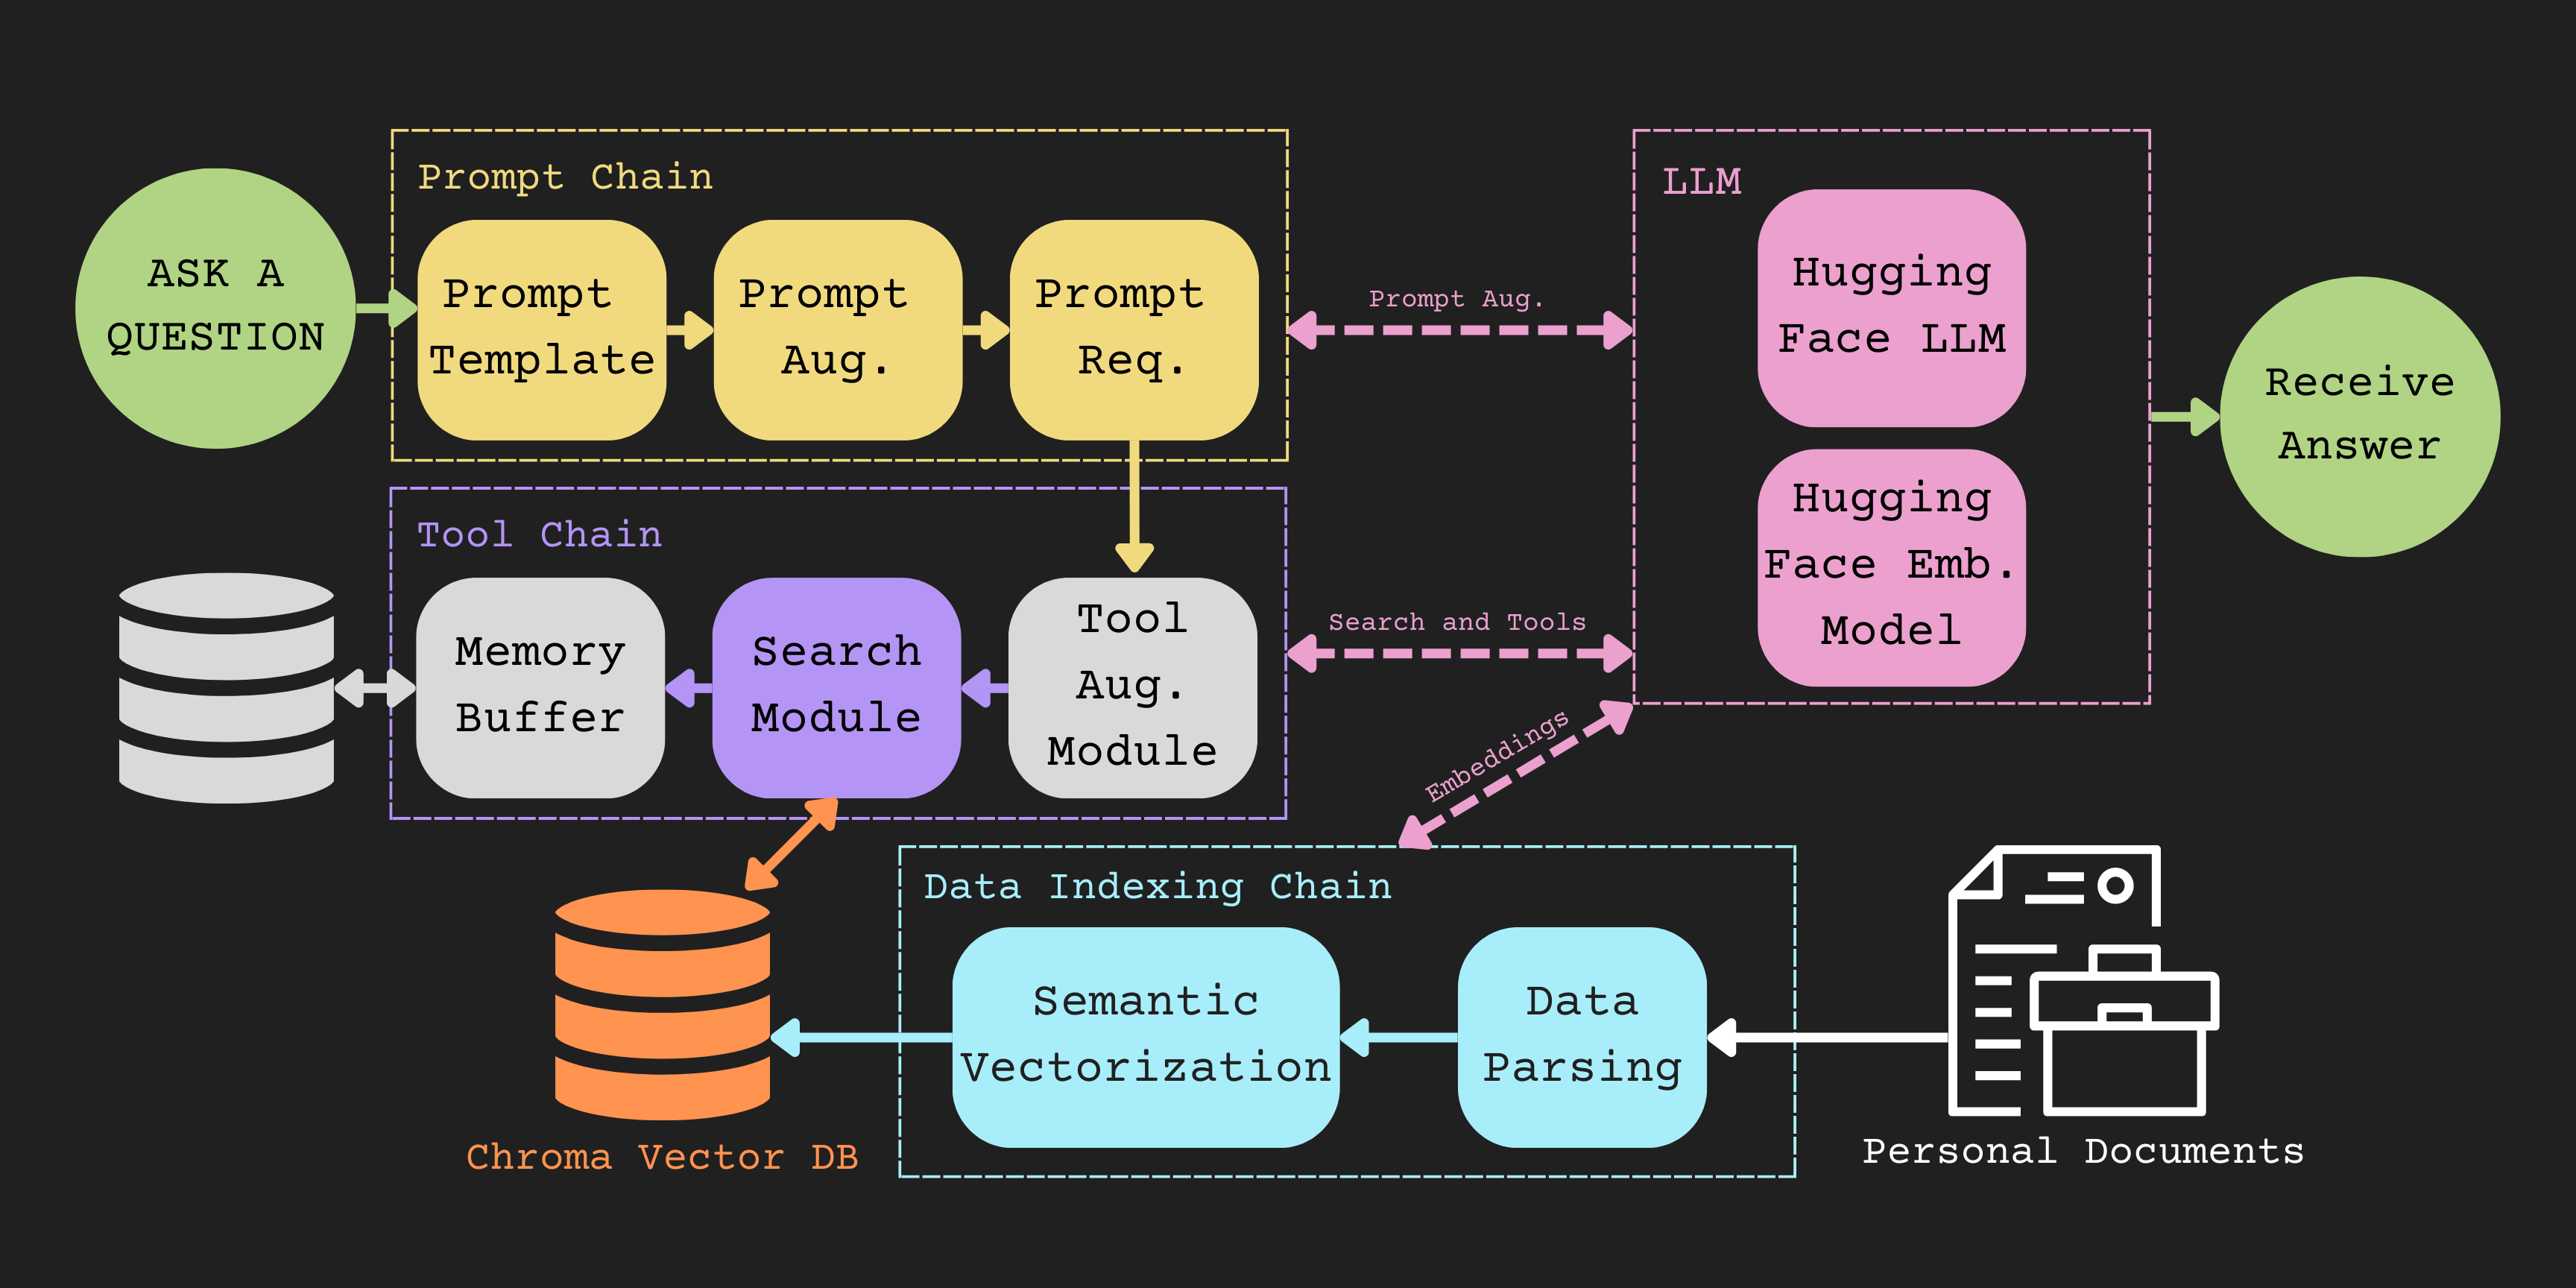

We're going to be leveraging Hugging Face's open source models to keep everything "on prem" today!



As before, we're going to be leveraging the instruct-tuned version of BLOOM, BLOOMZ.

For ease of use, we'll be using BLOOMZ-1b7 - though the model choice is ultimately up to you.

In [26]:
!pip install langchain -q

### Loading Source Data

We'll be focusing on this section of the diagram for our data.

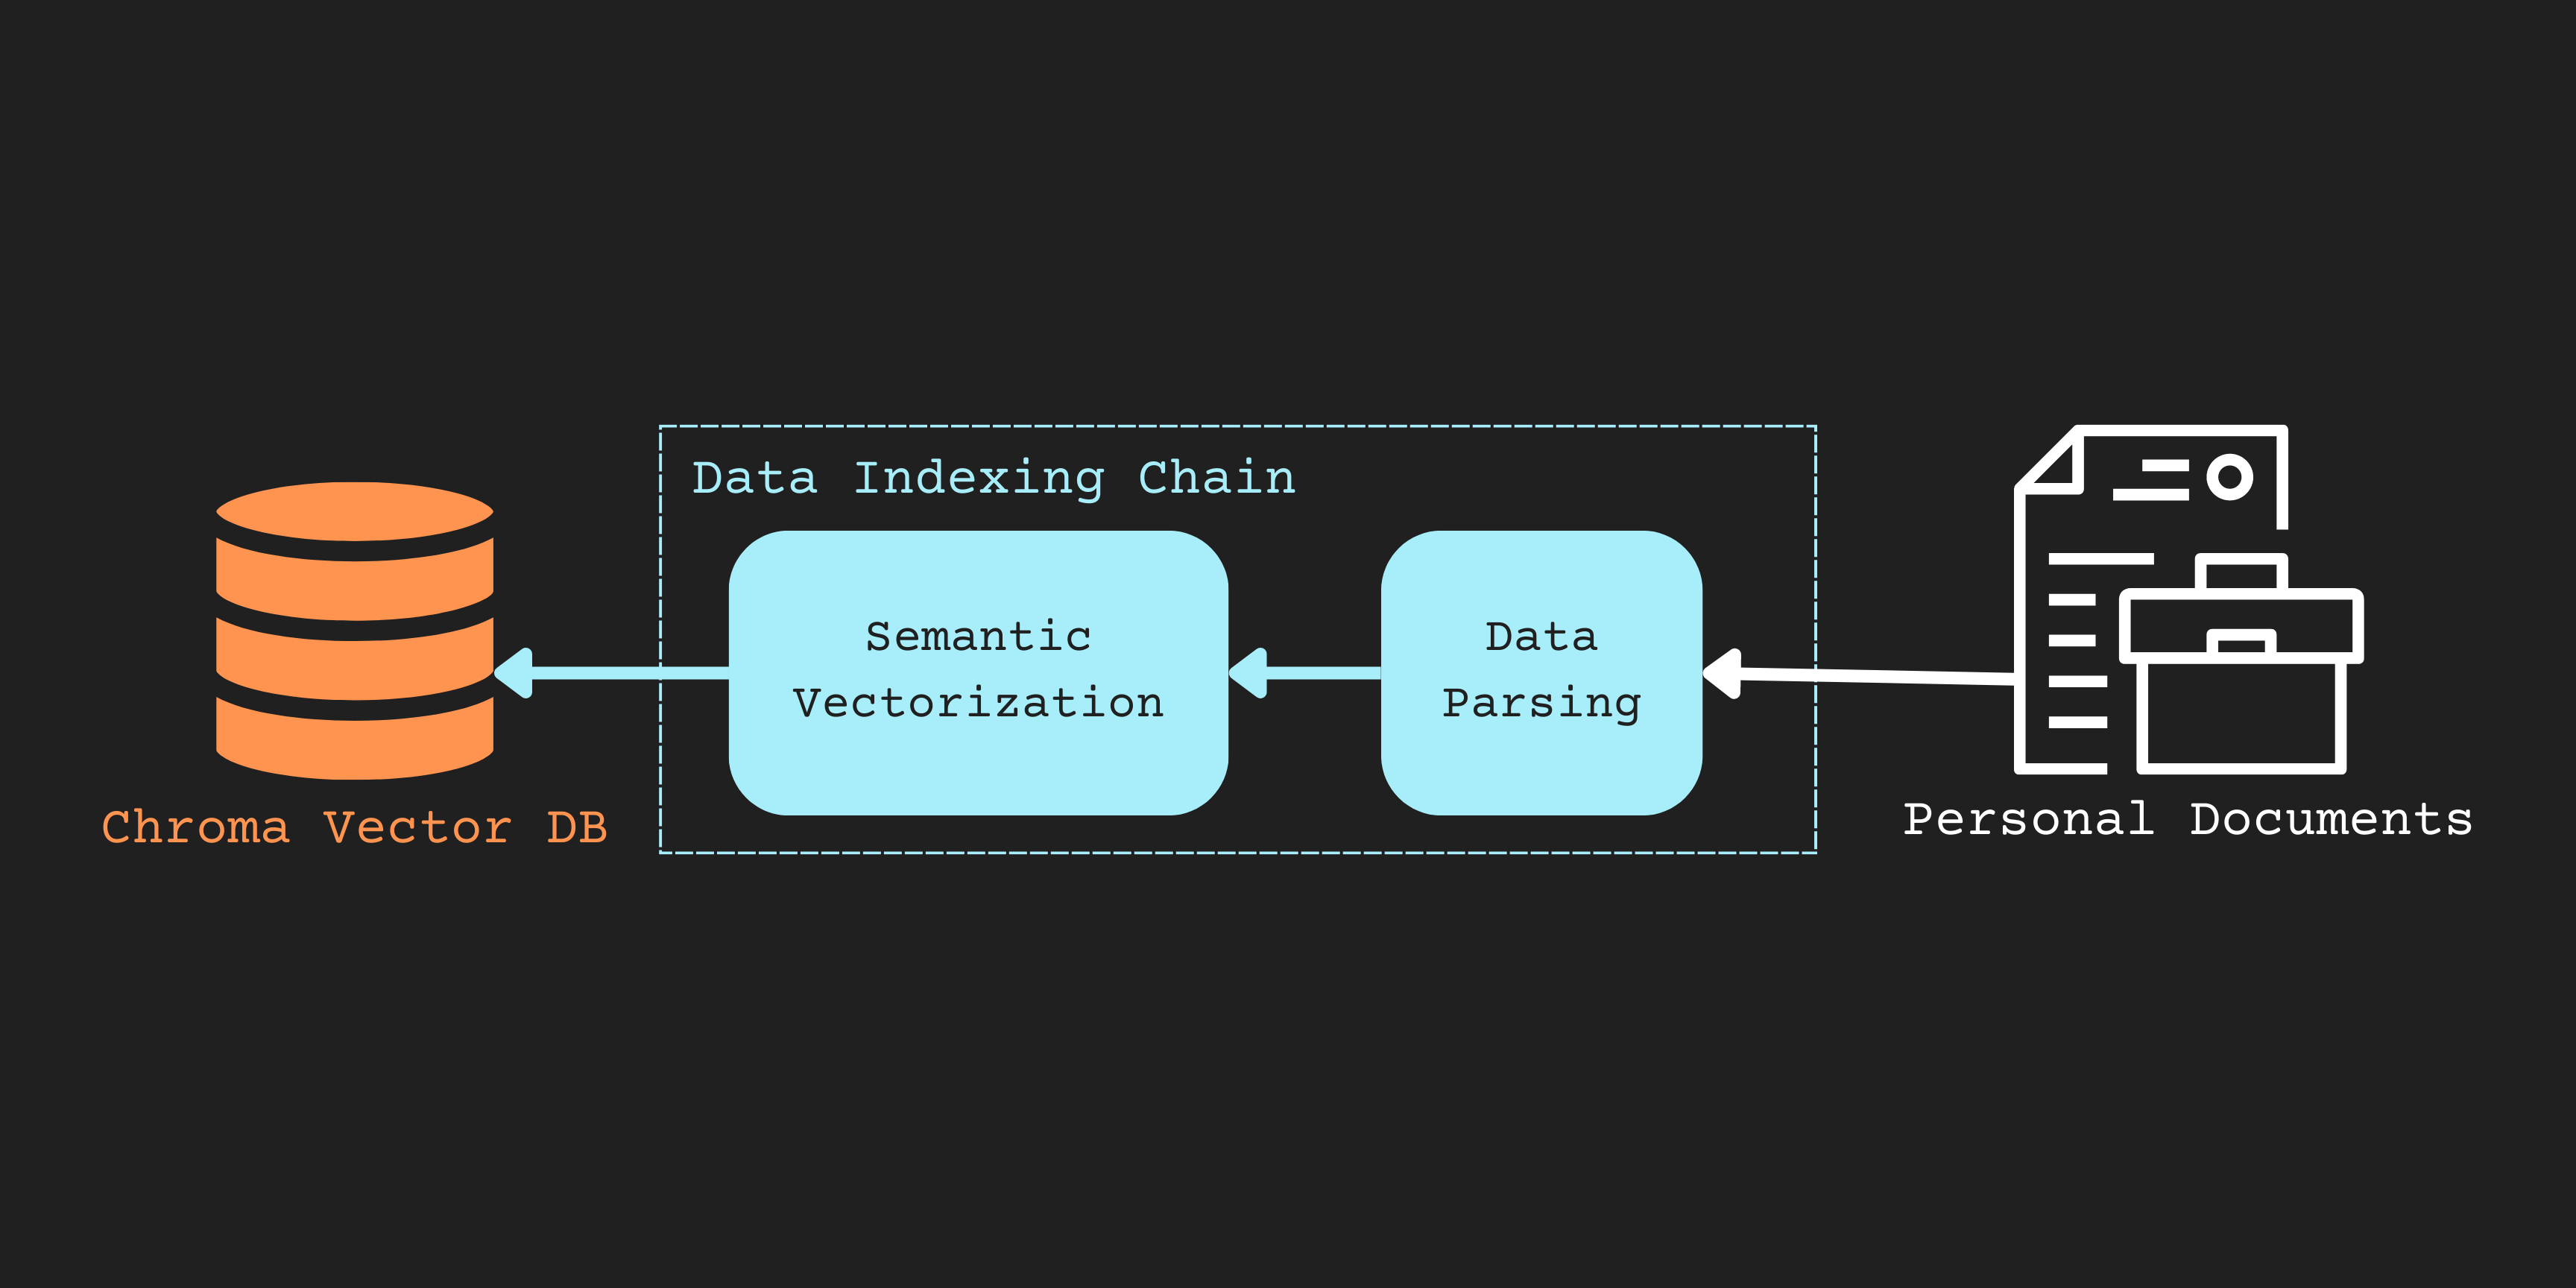

In order to get started, we'll first need a number of documents that we want to collect and manage.

We'll start with a number of HTML documents provided by [TheMITTech/shakespeare](https://github.com/TheMITTech/shakespeare).

Let's clone that repository to get started!

In [27]:
!git clone https://github.com/TheMITTech/shakespeare

fatal: destination path 'shakespeare' already exists and is not an empty directory.


Let's collect all the HTML documents into a single directory.

In [29]:
from glob import glob

files = glob("./shakespeare/**/*.html")

In [33]:
import shutil
import os

#os.mkdir('./data')
destination_folder = './data/'

for html_file in files:
  shutil.move(html_file, destination_folder + html_file.split("/")[-1])

While we'll be using this collection of HTML documents for the remainder of this example - you could use any collection of data that you wanted!

Have a look at [this link](https://python.langchain.com/en/latest/modules/indexes/document_loaders.html) to see the full number of `DocumentLoader`s available.

Now that we have our documents downloaded, let's load them with a combination of `DirectoryLoader` and `BSHTMLLoader`, which is the BeautifulSoup4 powered `HTMLLoader`. We're using this to give us a bit more metadata for our documents.

In [34]:
# install dependencies
!pip install beautifulsoup4 -q

In [35]:
from langchain.document_loaders import BSHTMLLoader, DirectoryLoader

bshtml_dir_loader = DirectoryLoader('./data/', loader_cls=BSHTMLLoader)

data = bshtml_dir_loader.load()

Now that we have our data loaded (with additional metadata thanks to the `BSHTMLLoader`), we can move onto splitting those documents into appropriately sized pieces!

Because we're keeping things "on prem", let's get some Hugging Face dependencies.

In [36]:
!pip install transformers huggingface-hub -q

In [8]:
from transformers import AutoTokenizer

bloomz_tokenizer = AutoTokenizer.from_pretrained('bigscience/BLOOMZ-1b7')

Now that we have our tokenizer - let's split our documents into bitesized pieces! Let's split our documents on the newline character!

In [37]:
from langchain.text_splitter import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(bloomz_tokenizer, chunk_size=100, chunk_overlap=0, separator="\n")

documents = text_splitter.split_documents(data)

Now that we have our documents split - we need to convert them into embeddings!

True to staying "on-prem" we will be using Hugging Face Hub embedding models to achieve this goal!

Remember, everything we're using today is only an example - feel free to extend/modify wherever you see fit!

In [38]:
# we'll need the sentence transformers library to utilize HF's Sentence XFormer for our embeddings.
!pip install sentence_transformers -q

In [39]:
from langchain.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings()

Now we can embed our chunked documents into a ChromaVectorDB!

We are going to be going through the example of persisting this particular DB - but we won't be leveraging the persisted version.

For the example, we just want to showcase how you would persist this particular VectorDB.

You'll notice that there is some GPU usage during this process - since we're leveraging Sentence Transformers to do our embeddings.

It will also take some time, for that same reason.

In [40]:
# we'll need a few dependencies before we can do this
!pip install chromadb -q

In [44]:
from langchain.vectorstores import Chroma

persist_directory = "vector_db"

vectordb = Chroma.from_documents(documents=documents, embedding=embeddings, persist_directory=persist_directory)

Now we can persist our Chroma vector store - and then show an example of how you would load that persisted vector store.

In [45]:
vectordb.persist()
vectordb = None


As you can see when you run the following cell - loaded the persisted vectore store is *much* quicker than reinstantiating it - and that is the benefit of `persist_directory`!

In [48]:
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embeddings)

Now that we have our docs set-up - we're ready to progress to the next part of the LangChain applciation puzzle!

### Tool Chain

Now we can leverage our `oc_retriever` as a tool in our LangChain application!

We'll be utilizing the BLOOMZ-1b7 model as our LLM today - so we can expect that our results will be less effective than if we used OpenAI's gpt-3.5-turbo, but the advantage is that no information will escape outside of our Colab environment.

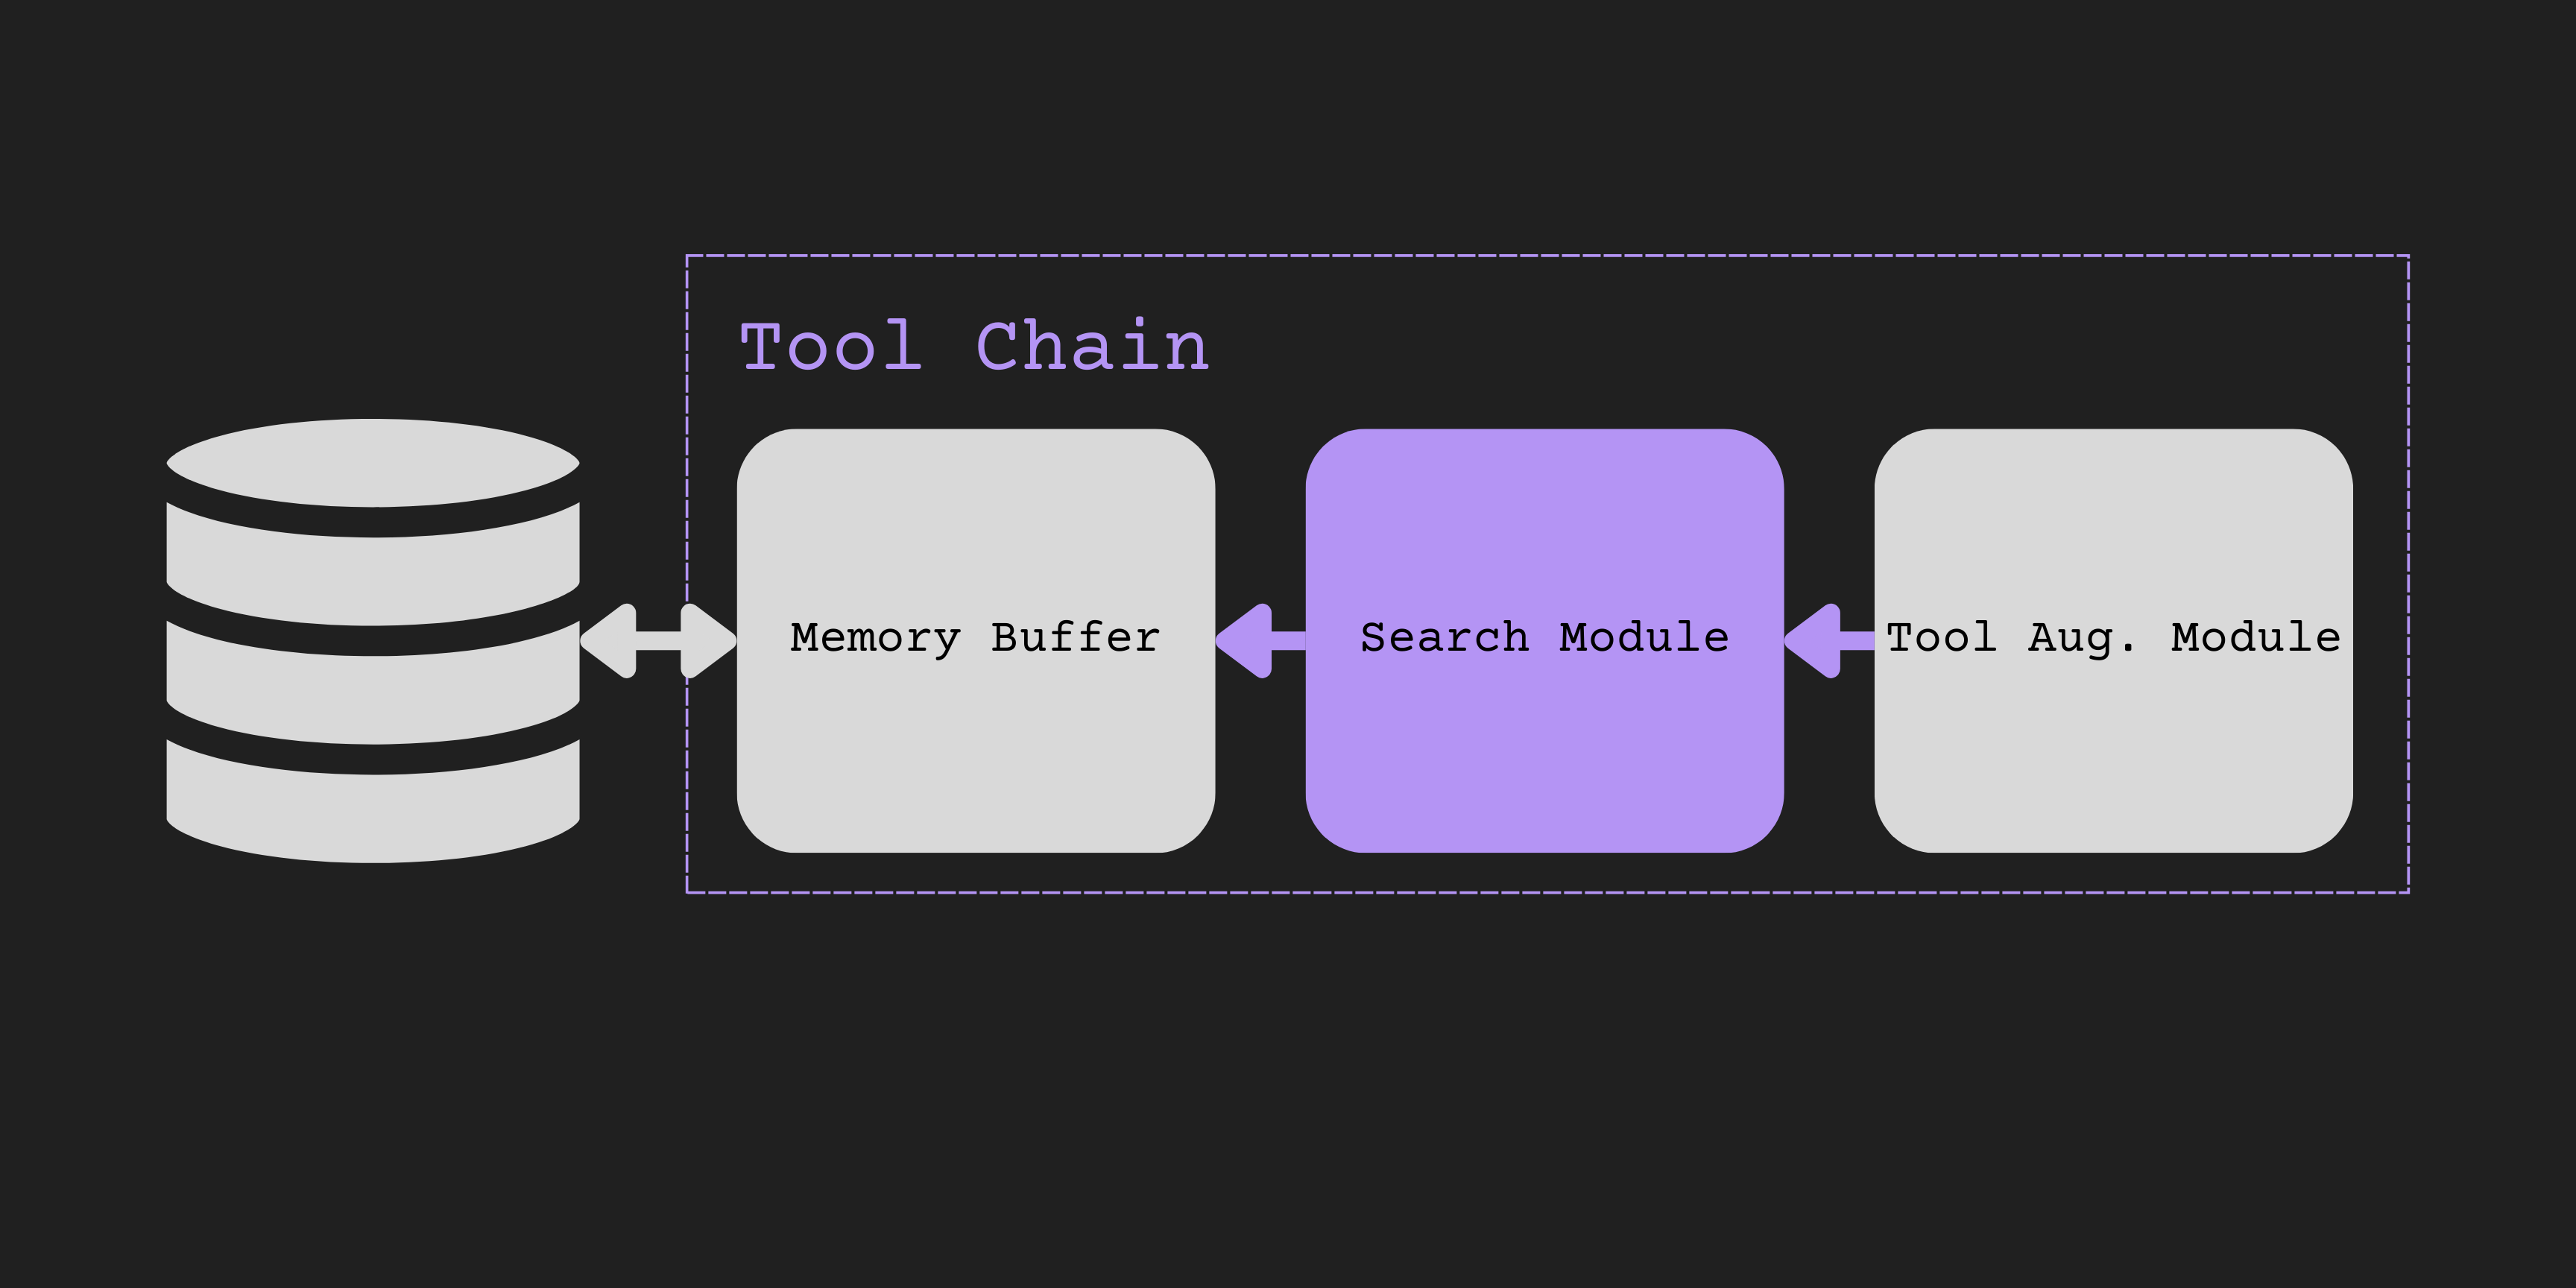

First up, let's load our model!

In [49]:
from langchain import HuggingFacePipeline

llm = HuggingFacePipeline.from_model_id(
    model_id="bigscience/bloomz-1b7",
    task="text-generation",
    model_kwargs={"temperature" : 0, "max_length" : 500})

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


Now let's set up our document vector store as a Retriever tool so we can leverage it in our chain!

In [50]:
doc_retriever = vectordb.as_retriever()

### Final Chain

With that set-up, we're good to set-up our final RetrievalQA chain and leverage all the documents we have in our Vector DB!

In [51]:
from langchain.chains import RetrievalQA

shakespeare_qa = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=doc_retriever)

Let's test it out by itself!

In [52]:
shakespeare_qa.run("Who was Hamlet's Mother?")

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


' Queen Gertrude'

### Conclusion

Here we have it!

A system capable of querying over multiple documents - all without every needing to hit an external API!